# VaR and ES(CVaR) for a balanced portfolio of Magnificent 7

Step 1 : Downloading the required packagess
Step 2 : Download the relevant data from Yahoofinance 
Step 3 : Calculate Portfolio Stats 
Step 4 : Simulate 10,000 portfolios through simulation 


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization 
from IPython.display import display

,Annualized Return
AAPL,22.20%
AMZN,14.91%
GOOG,22.70%
NVDA,59.71%
TSLA,47.29%
MSFT,21.36%
META,22.35%



--- Optimal Portfolio Weights (Max Sharpe) ---


,Weight
AAPL,13.60%
AMZN,0.00%
GOOG,25.50%
NVDA,40.00%
TSLA,18.90%
MSFT,2.00%
META,0.00%


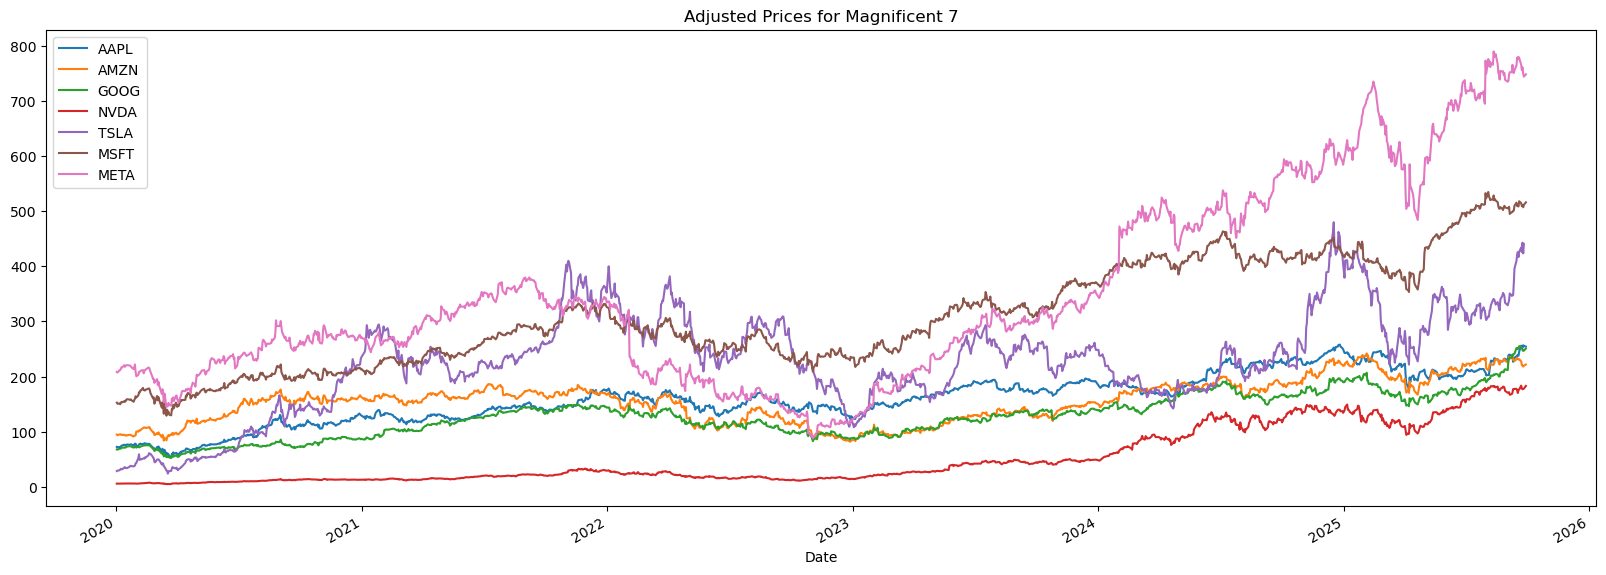

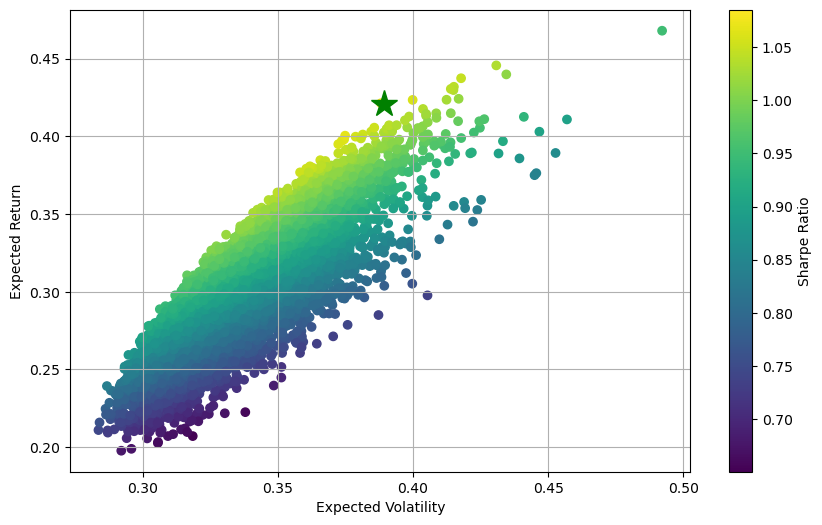

,Expected Annual Return,Expected Annual Volatility,Maximum Sharpe Ratio,99% Daily VaR,99% Daily ES
0,42.04%,38.93%,0.964,6.75%,8.43%


In [21]:
# downloading the data 

stocks = [ 'AAPL' ,  'AMZN' , 'GOOG' , 'NVDA' , 'TSLA' , 'MSFT' , 'META' ] # Magnificent 7 
start_date = '2020-01-01'
#end_date = '2025-09-18' # if I do not provide an end date it will automatically be selected as of today

num_td = 252 # Number of Trading days 
num_port = 10000 # taken 10000 for quicker processing
rf = 0.045

def data_download():
    stock_data = {}
    for i in stocks: 
        ticker = yf.Ticker(i)
        stock_data[i] = ticker.history(start = start_date , interval = '1d', auto_adjust=False)['Adj Close'] #  end = end_date
    return pd.DataFrame(stock_data)

def plot_stock_prices(data):
    data.plot( figsize = (20,7))
    plt.show()

def calculate_log_returns(data):
     # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data/data.shift(1)) # here I have moved the index by 1 so that previous data values will be fetched
    #print(log_return)
    log_return = log_return.dropna()
    return log_return[1:]

def show_stats(returns):
    annual_mean = returns.mean()*num_td
    annual_cov = returns.cov()*num_td
    annual_corr = returns.corr()
    pd.options.display.float_format = '{:0.3f}'.format
    #print(f'(\nAnnual mean return of the respective stocks in the portfolio  \n{annual_mean})')
    display(annual_mean.to_frame("Annualized Return").style.format("{:.2%}"))
    # print(f'(\nAnnual Covariance of the respective stocks  \n{annual_cov})')
    # print(f'(\nAnnual Correlation of the respective stocks  \n{annual_corr})')

# Next step is to go portfolio level 

def port_mean_variance(returns, weights): # this functions calculates the mean and variance for the balanced portfolio and equally weighted portfolio
    #eq_wt = np.full(len(returns.columns), 1 / len(returns.columns))
    portfolio_return = np.sum(returns.mean()*weights )*num_td
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot( returns.cov()*num_td, weights)))
    print(f'( Expected Portfolio Retutns (Optimised Port) \n{portfolio_return})')
    print(f'( Expected Portfolio Volatility( Optimised Port) \n{portfolio_volatility})')


def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c= returns/volatilities, marker = 'o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()
    
# Next I will run the Monte Carlo simulation to generate thousands of portfolios

def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(num_port):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * num_td)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()* num_td, w))))
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def port_statistics(weights, returns):
    portfolio_return = np.sum(returns.mean()*weights )*num_td
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot( returns.cov()*num_td, weights)))
    return np.array([portfolio_return, portfolio_volatility, (portfolio_return-rf)/portfolio_volatility])

# Now I will calculate the optimal portfolio 

# First I will use the above function since and fetch the sharpe ratio since scioy can only minimsise functions 



def min_function_sharpe(weights, returns):
    return - port_statistics(weights,returns)[2]
    
# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize

def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights is 0.4, which means no more than 40% of money can be invested into a single stock
    max_weight_limit = 0.40
    bounds = tuple((0, max_weight_limit) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    optimal_weights = optimum['x'].round(3)
    metrics = port_statistics(optimal_weights, returns)
    print("\n--- Optimal Portfolio Weights (Max Sharpe) ---")
    weights_df = pd.DataFrame({"Weight": optimal_weights}, index=stocks)
    display(weights_df.style.format("{:.2%}"))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(port_statistics(opt['x'], rets)[1], port_statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


def calculate_var(weights, returns, confidence=0.99):
    """Calculate Value-at-Risk (VaR) and Expected Shortfall (ES) at given confidence."""
    port_daily_returns = returns.dot(weights)
    port_daily_losses = -port_daily_returns
    var = np.percentile(port_daily_losses, 100*confidence)
    es = port_daily_losses[port_daily_losses > var].mean()
    return var, es


if __name__ == '__main__':
    # --- Data download & prep ---
    stock_prices = data_download()
    stock_prices.plot(figsize=(20, 7), title='Adjusted Prices for Magnificent 7')

    log_daily_returns = calculate_log_returns(stock_prices)

    # --- Portfolio simulation & optimization ---
    pweights, means, risks = generate_portfolios(log_daily_returns)
    optimum = optimize_portfolio(pweights, log_daily_returns)

    # --- Analytics ---
    show_stats(log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

    # --- Risk metrics ---
    var, es = calculate_var(optimum['x'], log_daily_returns, confidence=0.99)

    # --- Final tidy summary table ---
    port_ret, port_vol, port_sharpe = port_statistics(optimum['x'], log_daily_returns)
    summary_df = pd.DataFrame([{
        "Expected Annual Return": port_ret,
        "Expected Annual Volatility": port_vol,
        "Maximum Sharpe Ratio": port_sharpe,
        "99% Daily VaR": var,
        "99% Daily ES": es
    }])

    display(
        summary_df.style.format({
            "Expected Annual Return": "{:.2%}",
            "Expected Annual Volatility": "{:.2%}",
            "Maximum Sharpe Ratio": "{:.3f}",
            "99% Daily VaR": "{:.2%}",
            "99% Daily ES": "{:.2%}"
        }).set_table_styles(
            [{'selector': 'th', 'props': [('font-weight', 'bold'),
                                          ('text-align', 'center')]}]
        )
    )


